Chu kỳ cao điểm chính ~ 23.91 giờ
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


355/355 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.0358
Epoch 2/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0014
Epoch 3/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0017
Epoch 4/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0014
Epoch 5/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0014
Epoch 6/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0014
Epoch 7/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0013
Epoch 8/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0012
Epoch 9/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0012
Epoch 10/10
355/355 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0011


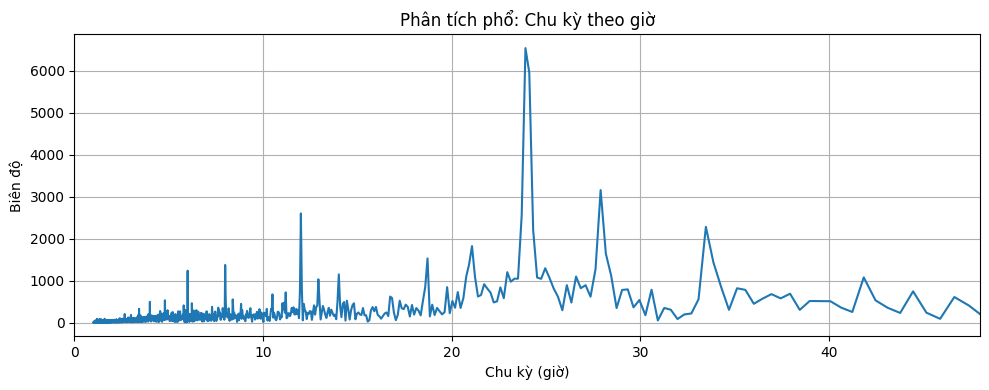

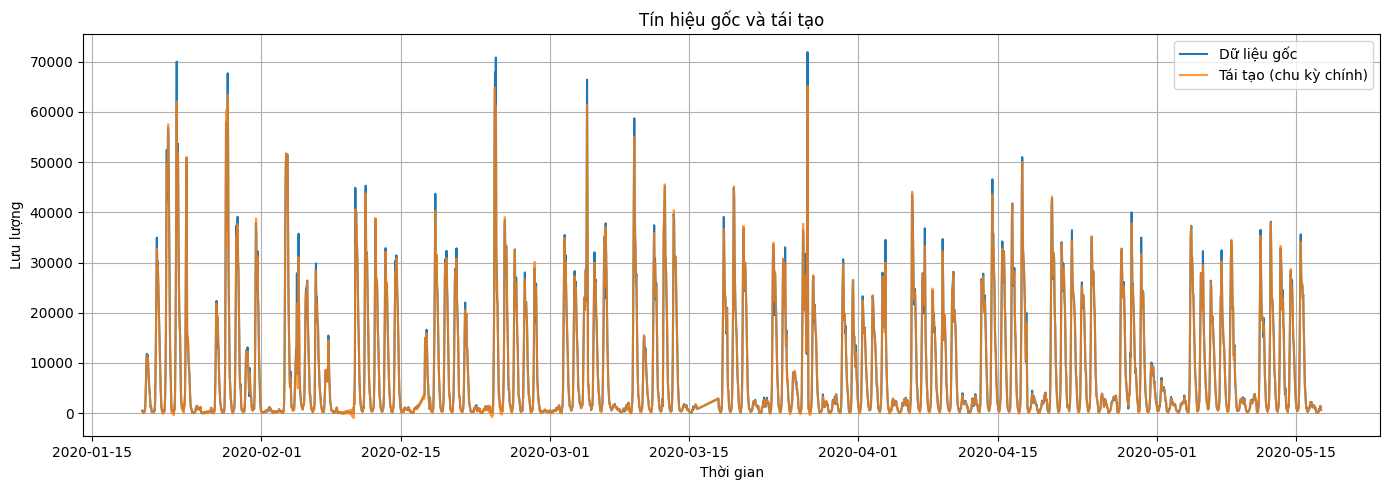

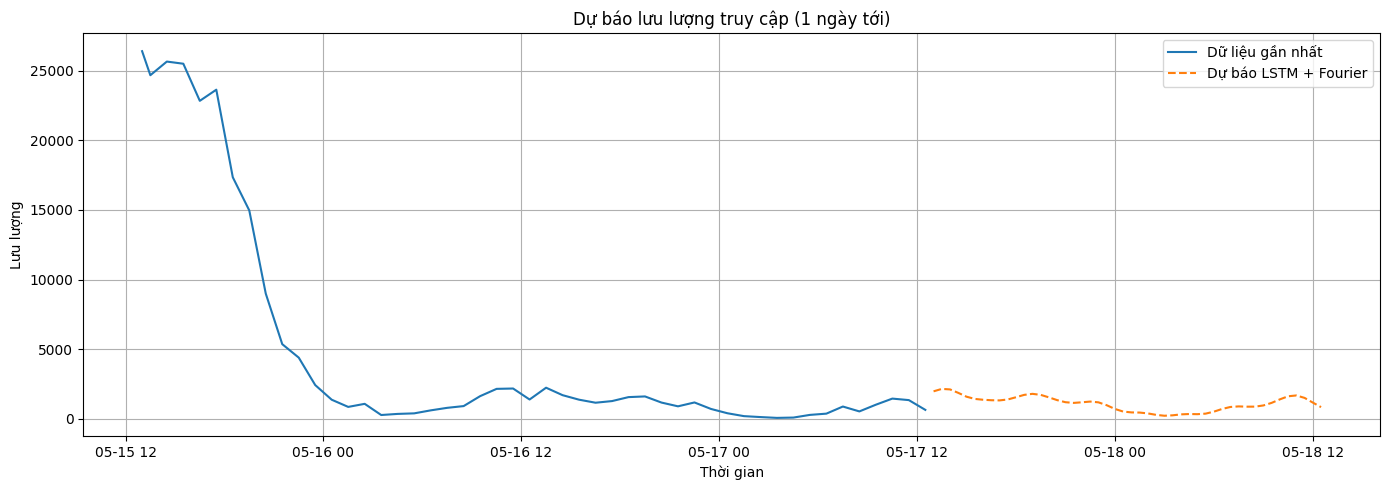

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# --- Bước 1: Đọc dữ liệu ---
df = pd.read_csv('/content/web_traffic.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')
df.set_index('Timestamp', inplace=True)

# --- Bước 2: Chuẩn hóa dữ liệu ---
df = df.resample('30min').mean().interpolate()
traffic = df['TrafficCount'].values
N = len(traffic)
T = 1800  # 30 phút = 1800 giây

# --- Bước 3: Biến đổi Fourier ---
fft_vals = fft(traffic)
freqs = fftfreq(N, T)

# Lọc tần số dương
pos_mask = freqs > 0
amplitudes = 2.0 / N * np.abs(fft_vals[pos_mask])
dominant_freq = freqs[pos_mask][np.argmax(amplitudes)]
dominant_period_hours = 1 / dominant_freq / 3600
print(f"Chu kỳ cao điểm chính ~ {dominant_period_hours:.2f} giờ")

# --- Bước 4: Lọc tín hiệu theo tần số chính và đối xứng ---
mask = (np.abs(freqs - dominant_freq) < 1e-4) | (np.abs(freqs + dominant_freq) < 1e-4)
fft_filtered = np.zeros_like(fft_vals)
fft_filtered[mask] = fft_vals[mask]
reconstructed = np.real(ifft(fft_filtered))
df['Reconstructed'] = reconstructed

# --- Bước 5: Tách phần dư (residual) để LSTM dự báo ---
residual = traffic - reconstructed

# Chuẩn hóa phần dư
scaler = MinMaxScaler()
residual_scaled = scaler.fit_transform(residual.reshape(-1,1))

# Hàm tạo chuỗi dữ liệu cho LSTM
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 24  # 12 giờ (24 bước 30 phút)
X, y = create_sequences(residual_scaled, window_size)

# --- Bước 6: Xây dựng mô hình LSTM ---
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Dừng sớm nếu loss không giảm sau 5 epoch
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Huấn luyện mô hình
model.fit(X, y, epochs=10, batch_size=16, verbose=1, callbacks=[early_stop])

# --- Bước 7: Dự báo phần dư trong tương lai ---
forecast_steps = 48  # 1 ngày (48 bước 30 phút)
input_seq = residual_scaled[-window_size:]
forecast_residual = []

for _ in range(forecast_steps):
    input_reshaped = input_seq.reshape(1, window_size, 1)
    next_val = model.predict(input_reshaped, verbose=0)[0,0]
    forecast_residual.append(next_val)
    input_seq = np.append(input_seq[1:], next_val)

forecast_residual = scaler.inverse_transform(np.array(forecast_residual).reshape(-1,1)).flatten()

# Lặp lại chu kỳ chính (reconstructed) phần tương lai
forecast_cycle = reconstructed[-forecast_steps:]

# Cộng phần chu kỳ với phần dư dự báo để có kết quả cuối cùng
forecast_total = forecast_cycle + forecast_residual

# --- Bước 8: Chuẩn bị dữ liệu dự báo để vẽ ---
future_dates = pd.date_range(df.index[-1] + pd.Timedelta(minutes=30), periods=forecast_steps, freq='30min')
forecast_df = pd.DataFrame({'Timestamp': future_dates, 'Forecast': forecast_total})
forecast_df.set_index('Timestamp', inplace=True)

# --- Bước 9: Vẽ kết quả ---

# Phổ tần số
plt.figure(figsize=(10, 4))
plt.plot(1 / freqs[pos_mask] / 3600, amplitudes)
plt.title('Phân tích phổ: Chu kỳ theo giờ')
plt.xlabel('Chu kỳ (giờ)')
plt.ylabel('Biên độ')
plt.grid()
plt.xlim(0, 48)
plt.tight_layout()
plt.show()

# Dữ liệu gốc và tín hiệu tái tạo
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['TrafficCount'], label='Dữ liệu gốc')
plt.plot(df.index, df['Reconstructed'], label='Tái tạo (chu kỳ chính)', alpha=0.8)
plt.legend()
plt.title('Tín hiệu gốc và tái tạo')
plt.xlabel('Thời gian')
plt.ylabel('Lưu lượng')
plt.grid()
plt.tight_layout()
plt.show()

# Dự báo tương lai (chu kỳ + LSTM residual)
plt.figure(figsize=(14, 5))
plt.plot(df.index[-96:], df['TrafficCount'].values[-96:], label='Dữ liệu gần nhất')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Dự báo LSTM + Fourier', linestyle='--')
plt.title('Dự báo lưu lượng truy cập (1 ngày tới)')
plt.xlabel('Thời gian')
plt.ylabel('Lưu lượng')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
